In [1]:
%%capture
%cd ../../

In [2]:
import sys

sys.path.extend(["recommender"])

In [3]:
import pandas as pd
import warnings

warnings.simplefilter("ignore")
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn
import warnings
from sklearn.decomposition import NMF
import typing as t
from utils.encodes import gen_encode_cols
from utils.feature_eng import create_importance_dataframe
from utils.io import gen_dict, drop_cols

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

ImportError: cannot import name 'create_importance_dataframe' from 'utils.feature_eng' (/home/ec2-user/SageMaker/recommender/utils/feature_eng.py)

In [ ]:
current_dir = Path.cwd()
data_dir = current_dir.joinpath("recommender/data")
filename = "kaggle_survey_2017_2021.csv"

In [ ]:
data = pd.read_csv(data_dir.joinpath(filename), skiprows=1)
data = data.iloc[:, 2:250]
data = data[~data["What is your age (# years)?"].isna()]
data = data.fillna(0)
data.shape
print(data.shape)

In [ ]:
encode_df = gen_encode_cols(data)
encode_df.shape

In [ ]:
def group_feats(col_list: list, input_df: pd.DataFrame, new_col: str) -> pd.DataFrame:
    """
    Group the feats based on the question and options

    """
    merge_df = input_df.copy(deep=True)
    false_index = []
    true_index = []
    for col in col_list:
        if "None" in col or "No" in col:
            false_list = list(set(input_df[input_df[col] == 1].index))
            false_index.append(false_list)
        else:
            true_list = list(set(input_df[input_df[col] == 1].index))
            true_index.append(true_list)
    merge_df.loc[true_list, new_col] = 1
    merge_df.loc[false_list, new_col] = 0
    merge_df = merge_df.fillna(0)
    return merge_df


def count_selected_options(
    col_list: t.List[str], input_df: pd.DataFrame, new_col: str
) -> pd.DataFrame:
    """
    Count the options for a particular question belonging to a category
    """
    input_df[new_col] = 0
    for index, row in input_df.iterrows():
        count = 0
        for col in col_list:
            if "None" in col or "No" in col:
                pass
            else:
                value = input_df.loc[index, col]
                if value:
                    count += 1
                else:
                    count = count
        input_df.loc[index, new_col] = count
    return input_df


def merge_dfs(dfs: t.List[pd.DataFrame], main_df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for df in dfs:
        final_df = pd.concat([final_df, df.iloc[:, -1:]], axis=1)
    main_df = pd.concat([main_df, final_df], axis=1)
    return main_df

In [ ]:
platform_ds = [col for col in encode_df.columns if "data science courses" in col]
pgm_lang = [col for col in encode_df.columns if "programming languages" in col]
ide = [col for col in encode_df.columns if "IDE's" in col]
notebooks = [col for col in encode_df.columns if "hosted notebook" in col]
data_viz = [col for col in encode_df.columns if "data visualization" in col]
ml_framework = [
    col for col in encode_df.columns if "machine learning frameworks" in col
]
ml_algo = [col for col in encode_df.columns if "ML algorithms" in col]
comp_vision = [col for col in encode_df.columns if "computer vision" in col]
nlp_method = [col for col in encode_df.columns if "(NLP) methods" in col]
cloud_compute = [col for col in encode_df.columns if "cloud computing platforms" in col]
automate_ml = [col for col in encode_df.columns if "automated" in col]
business_intel = [col for col in encode_df.columns if "business intelligence" in col]
big_data = [col for col in encode_df.columns if "big data products" in col]
managed_ml = [col for col in encode_df.columns if "managed machine learning" in col]

In [26]:
platform_df = group_feats(platform_ds, encode_df, "Has taken DS Course")
pgm_lang_df = group_feats(pgm_lang, encode_df, "Knows Pgm Lang")
ide_df = group_feats(ide, encode_df, "Uses IDE for dev")
notebooks_df = group_feats(notebooks, encode_df, "Uses Notebooks for dev")
data_viz_df = group_feats(platform_ds, encode_df, "Uses Data Visualization libs")
ml_framework_df = group_feats(ml_framework, encode_df, "Uses ML Framework")
ml_algo_df = group_feats(ml_algo, encode_df, "Uses ML Algorithms")
cv_df = group_feats(comp_vision, encode_df, "Uses Computer Vision Algorithms")
nlp_df = group_feats(nlp_method, encode_df, "Uses NLP Algorithms")
automate_df = group_feats(automate_ml, encode_df, "Uses Auto ML tools")
business_intel_df = group_feats(business_intel, encode_df, "Uses Business Intel tools")
big_data_df = group_feats(big_data, encode_df, "Uses Big Data Products")
managed_ml_df = group_feats(managed_ml, encode_df, "Has Managed ML tools")
cloud_compute_df = group_feats(
    cloud_compute, encode_df, "Knows Cloud Compute Platforms"
)

In [10]:
## Count of options
count_platform_df = count_selected_options(
    platform_ds, encode_df, "Has taken DS Course Count"
)
count_pgm_lang_df = count_selected_options(pgm_lang, encode_df, "Knows Pgm Lang Count")
count_ide_df = count_selected_options(ide, encode_df, "Uses IDE for dev Count")
count_notebooks_df = count_selected_options(
    notebooks, encode_df, "Uses Notebooks for dev Count"
)
count_data_viz_df = count_selected_options(
    platform_ds, encode_df, "Uses Data Visualization libs Count"
)
count_ml_framework_df = count_selected_options(
    ml_framework, encode_df, "Uses ML Framework Count"
)
count_ml_algo_df = count_selected_options(
    ml_algo, encode_df, "Uses ML Algorithms Count"
)
count_cv_df = count_selected_options(
    comp_vision, encode_df, "Uses Computer Vision Algorithms Count"
)
count_nlp_df = count_selected_options(
    nlp_method, encode_df, "Uses NLP Algorithms Count"
)
count_automate_df = count_selected_options(
    automate_ml, encode_df, "Uses Auto ML tools Count"
)
count_business_intel_df = count_selected_options(
    business_intel, encode_df, "Uses Business Intel tools Count"
)
count_big_data_df = count_selected_options(
    big_data, encode_df, "Uses Big Data Products Count"
)
count_managed_ml_df = count_selected_options(
    managed_ml, encode_df, "Has Managed ML tools Count"
)
count_cloud_compute_df = count_selected_options(
    cloud_compute, encode_df, "Knows Cloud Compute Platforms Count"
)

In [11]:
encode_df.shape

(105856, 262)

In [12]:
group_dfs = [
    platform_df,
    pgm_lang_df,
    ide_df,
    notebooks_df,
    data_viz_df,
    ml_framework_df,
    ml_algo_df,
    cv_df,
    nlp_df,
    cloud_compute_df,
    automate_df,
    business_intel_df,
    big_data_df,
    managed_ml_df,
]
encode_df = merge_dfs(group_dfs, encode_df)

In [13]:
encode_df.shape

(105856, 276)

In [14]:
q_dict = gen_dict(data)
q_dict

{0: 'What is your age (# years)?',
 1: 'What is your gender? - Selected Choice',
 2: 'In which country do you currently reside?',
 3: 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 4: 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 5: 'For how many years have you been writing code and/or programming?',
 6: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
 7: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R',
 8: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL',
 9: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C',
 10: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++',
 1

In [15]:
code_exp_label = {
    "0": 0,
    "I have never written code and I do not want to learn": 0,
    "I have never written code": 0,
    "I don't write code to analyze data": 0,
    "< 1 years": 1,
    "Less than a year": 1,
    "1 to 2 years": 2,
    "1-3 years": 3,
    "3-5 years": 4,
    "3 to 5 years": 4,
    "5-10 years": 5,
    "6-10 years": 5,
    "10-20 years": 6,
    "More than 10 years": 7,
    "20+ years": 8,
    "30-40 years": 8,
    "40+ years": 8,
}
data[q_dict.get(5)] = data[q_dict.get(5)].map(code_exp_label)
data[q_dict.get(5)] = data[q_dict.get(5)].fillna(0)

In [16]:
data[q_dict.get(5)].unique()

array([5., 8., 3., 1., 4., 6., 0., 7., 2.])

In [17]:
bachelors = ["Bachelorâ€™s degree", "Bachelor's degree"]
masters = ["Masterâ€™s degree", "Master's degree"]
doctoral = ["Doctoral degree", "Professional doctorate"]
highschool = [
    "Some college/university study without earning a bachelorâ€™s degree",
    "I did not complete any formal education past high school",
    "Some college/university study without earning a bachelor's degree",
]
none = [0, "I prefer not to answer"]

data.loc[data[q_dict.get(3)].isin(bachelors), q_dict.get(3)] = "Bachelors"
data.loc[data[q_dict.get(3)].isin(masters), q_dict.get(3)] = "Masters"
data.loc[data[q_dict.get(3)].isin(doctoral), q_dict.get(3)] = "Doctorate"
data.loc[data[q_dict.get(3)].isin(highschool), q_dict.get(3)] = "High-School"
data.loc[data[q_dict.get(3)].isin(none), q_dict.get(3)] = "None"

In [18]:
ohe_cols = [q_dict.get(3)]
ohe_df = pd.get_dummies(data[ohe_cols])
ohe_df.head(2)

,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Bachelors,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Doctorate,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_High-School,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Masters,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_No formal education past high school,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_None,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Professional degree
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0


In [19]:
age_label = {
    "18-21": 0,
    "22-24": 1,
    "25-29": 2,
    "30-34": 3,
    "35-39": 4,
    "40-44": 5,
    "45-49": 6,
    "50-54": 7,
    "55-59": 8,
    "60-69": 9,
    "70+": 10,
}

data["What is your age (# years)?"] = data["What is your age (# years)?"].map(age_label)

In [15]:
data[[q_dict.get(0), q_dict.get(5)]]

,What is your age (# years)?,For how many years have you been writing code and/or programming?
0,7,5.0
1,7,8.0
2,1,3.0
3,6,8.0
4,6,1.0
...,...,...
106295,1,0.0
106296,1,1.0
106297,2,2.0
106298,2,0.0


In [36]:
encode_df.shape

(105856, 276)

In [20]:
encode_df = pd.concat([encode_df, ohe_df], axis=1)
encode_df.shape

(105856, 283)

In [21]:
encode_df

,What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,For how many years have you been writing code and/or programming?,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C,...,Uses Business Intel tools,Uses Big Data Products,Has Managed ML tools,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Bachelors,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Doctorate,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_High-School,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Masters,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_No formal education past high school,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_None,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Professional degree
0,7,1,0,1,4,4,0,1,0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
1,7,1,18,0,16,8,1,0,1,1,...,0.0,0.0,0.0,0,0,0,1,0,0,0
2,1,1,17,0,2,5,0,0,0,0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
3,6,1,22,2,6,8,0,0,0,0,...,0.0,0.0,0.0,0,1,0,0,0,0,0
4,6,1,0,2,4,3,0,0,0,1,...,0.0,0.0,0.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106295,1,0,43,4,5,2,1,0,0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
106296,1,2,2,3,5,12,1,0,0,0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
106297,0,0,18,4,23,9,1,0,0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
106298,0,2,19,6,5,2,1,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,1,0


In [22]:
q_dict = gen_dict(encode_df)
q_dict

{0: 'What is your age (# years)?',
 1: 'What is your gender? - Selected Choice',
 2: 'In which country do you currently reside?',
 3: 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 4: 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 5: 'For how many years have you been writing code and/or programming?',
 6: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
 7: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R',
 8: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL',
 9: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C',
 10: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++',
 1

In [23]:
encode_df = drop_cols([0, 1, 2, 3, 5], encode_df, index_label=True)
encode_df = pd.concat([encode_df, data[[q_dict.get(0), q_dict.get(5)]]], axis=1)
encode_df

,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Java,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Javascript,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Julia,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Swift,...,Has Managed ML tools,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Bachelors,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Doctorate,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_High-School,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Masters,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_No formal education past high school,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_None,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Professional degree,What is your age (# years)?,For how many years have you been writing code and/or programming?
0,4,0,1,0,0,0,0,0,0,0,...,0.0,1,0,0,0,0,0,0,7,5.0
1,16,1,0,1,1,1,1,0,0,0,...,0.0,0,0,0,1,0,0,0,7,8.0
2,2,0,0,0,0,1,1,0,0,0,...,0.0,0,0,0,1,0,0,0,1,3.0
3,6,0,0,0,0,0,0,0,0,0,...,0.0,0,1,0,0,0,0,0,6,8.0
4,4,0,0,0,1,0,0,0,0,0,...,0.0,0,1,0,0,0,0,0,6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106295,5,1,0,0,0,0,0,0,0,0,...,0.0,1,0,0,0,0,0,0,1,0.0
106296,5,1,0,0,0,0,0,0,0,0,...,0.0,0,0,0,1,0,0,0,1,1.0
106297,23,1,0,0,0,0,0,0,0,0,...,0.0,1,0,0,0,0,0,0,2,2.0
106298,5,1,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,1,0,2,0.0


In [24]:
encode_df.shape

(105856, 280)

In [14]:
def drop_cols(cols: t.List[list], main_df: pd.DataFrame) -> pd.DataFrame:
    for col in cols:
        main_df = main_df.drop(columns=col)
    return main_df

In [75]:
col_list = [
    platform_ds,
    pgm_lang,
    ide,
    notebooks,
    data_viz,
    ml_framework,
    ml_algo,
    comp_vision,
    nlp_method,
    cloud_compute,
    automate_ml,
    business_intel,
    big_data,
    managed_ml,
]
encode_df = drop_cols(col_list, encode_df)

In [26]:
encode_df.columns

Index(['Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
       'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
       'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R',
       'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL',
       'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C',
       'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++',
       'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Java',
       'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Javascript',
       'What programming languages do you use on a regular basis? (

### Target label discussion


In [33]:
feat_df = encode_df.copy(deep=True)

In [34]:
feature_dict = gen_dict(data)
feature_dict

{0: 'What is your age (# years)?',
 1: 'What is your gender? - Selected Choice',
 2: 'In which country do you currently reside?',
 3: 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 4: 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 5: 'For how many years have you been writing code and/or programming?',
 6: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
 7: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R',
 8: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL',
 9: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C',
 10: 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++',
 1

In [35]:
data[feature_dict[4]].value_counts()

Student                                 21242
Data Scientist                          16910
Software Engineer                       10252
Data Analyst                             8489
Other                                    8346
0                                        6985
Research Scientist                       5371
Business Analyst                         4097
Currently not employed                   3638
Machine Learning Engineer                3192
Data Engineer                            2466
Product/Project Manager                  1843
Not employed                             1784
Software Developer/Software Engineer     1726
Statistician                             1451
Scientist/Researcher                      960
Program/Project Manager                   849
Consultant                                785
DBA/Database Engineer                     780
Researcher                                601
Research Assistant                        600
Manager                           

In [36]:
##Combine research scientist/SE

In [37]:
feat_df["Target"] = data[feature_dict[4]].copy()

In [38]:
se_list = ["Software Developer/Software Engineer", "Software Engineer"]
research_eng = ["Researcher", "Scientist/Researcher"]
feat_df.loc[feat_df["Target"].isin(se_list), "Target"] = "Software Engineer"
feat_df.loc[feat_df["Target"].isin(research_eng), "Target"] = "Researcher"

In [39]:
feat_df.shape

(105856, 281)

In [40]:
feat_df = feat_df.rename(columns={feat_df.columns[280]: "Target"})
feat_df = feat_df[feat_df["Target"] != "Currently not employed"]
feat_df.loc[feat_df["Target"] == 0, "Target"] = "Student"
feat_df.loc[feat_df["Target"] == 0, "Target"] = "Student"
se_list = ["Software Developer/Software Engineer", "Software Engineer"]
research_eng = ["Researcher", "Scientist/Researcher"]
feat_df.loc[feat_df["Target"].isin(se_list), "Target"] = "Software Engineer"
feat_df.loc[feat_df["Target"].isin(research_eng), "Target"] = "Researcher"
labels = [
    "Student",
    "Data Scientist",
    "Data Analyst",
    "Software Engineer",
    "Research Scientist",
    "Machine Learning/ MLops Engineer",
    "Data Engineer",
]
feat_df.loc[~feat_df["Target"].isin(labels), "Target"] = "Other"

In [41]:
feat_df.shape

(102218, 281)

In [42]:
feat_df["Target"].value_counts()

Other                 28777
Student               28227
Data Scientist        16910
Software Engineer     11978
Data Analyst           8489
Research Scientist     5371
Data Engineer          2466
Name: Target, dtype: int64

In [43]:
le = LabelEncoder()
feat_df["Target"] = le.fit_transform(feat_df["Target"])

In [44]:
feat_df = feat_df.fillna(0)

In [45]:
feat_df.head()

,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Java,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Javascript,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Julia,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Swift,...,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Bachelors,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Doctorate,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_High-School,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Masters,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_No formal education past high school,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_None,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Professional degree,What is your age (# years)?,For how many years have you been writing code and/or programming?,Target
0,4,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,7,5.0,3
1,16,1,0,1,1,1,1,0,0,0,...,0,0,0,1,0,0,0,7,8.0,3
2,2,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,3.0,5
3,6,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,6,8.0,4
4,4,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,6,1.0,3


In [46]:
feat_df.to_csv(data_dir.joinpath("Features_Kaggle.csv"), index=False)

### Read features data

In [4]:
feat_df = pd.read_csv(data_dir.joinpath("Features_Kaggle.csv"))
feat_df.shape

NameError: name 'data_dir' is not defined

In [15]:
train_df = feat_df.copy()
col_list = [
    platform_ds,
    pgm_lang,
    ide,
    notebooks,
    data_viz,
    ml_framework,
    ml_algo,
    comp_vision,
    nlp_method,
    cloud_compute,
    automate_ml,
    business_intel,
    big_data,
    managed_ml,
]
final_df = drop_cols(col_list, train_df)

In [17]:
feat_df = final_df.copy()
feat_df.head(2)

,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice,What type of computing platform do you use most often for your data science projects? - Selected Choice,Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - CPUs,Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - NVIDIA GPUs,Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud TPUs,Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - None,Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - Other,Approximately how many times have you used a TPU (tensor processing unit)?,For how many years have you used machine learning methods?,...,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Bachelors,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Doctorate,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_High-School,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Masters,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_No formal education past high school,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_None,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Professional degree,What is your age (# years)?,For how many years have you been writing code and/or programming?,Target
0,4,0,1,0,0,1,0,0,2,8,...,1,0,0,0,0,0,0,7,5.0,3
1,16,0,4,0,0,0,1,0,1,2,...,0,0,0,1,0,0,0,7,8.0,3


In [22]:
feat_df.shape

(102218, 95)

In [18]:
## Split the data into train and test
X = feat_df.iloc[:, 1:-1].values
y = feat_df["Target"].values
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"))
X, y = resample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

### Model Development

In [19]:
forest = RandomForestClassifier(
    criterion="gini", n_estimators=250, random_state=1, n_jobs=-1
)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=1)

### Reduced features

In [23]:
sorted_idx = forest.feature_importances_.argsort()
train_df = feat_df.iloc[:, 1:-1]
train_df.columns[sorted_idx]

Index(['Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice -  Sacred + Omniboard ',
       'Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice -  Domino Model Monitor ',
       'Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice -  Comet.ml ',
       'Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice -  Guild.ai ',
       'Uses Computer Vision Algorithms', 'Uses NLP Algorithms',
       'Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice -  NBViewer ',
       'Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice -  Polyaxon ',
       'Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Cho

In [30]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
train_df = feat_df.iloc[:, 1:-1].columns
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, train_df[indices[f]], importances[indices[f]]))

 1) What is your age (# years)?    0.068483
 2) What is the highest level of formal education that you have attained or plan to attain within the next 2 years?_Doctorate 0.045382
 3) What is your current yearly compensation (approximate $USD)? 0.043413
 4) Does your current employer incorporate machine learning methods into their business? 0.042361
 5) In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice 0.035614
 6) For how many years have you been writing code and/or programming? 0.034678
 7) What is the size of the company where you are employed? 0.029692
 8) Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions 0.029424
 9) Knows Pgm Lang Count           0.029022
10) For how many years have you used machine learning methods? 0.027248
11) Approximately how many individuals are responsible fo

#### With all the feattures included

sorted_idx = forest.feature_importances_.argsort()
train_df = feat_df.iloc[:,1:-1]
train_df.columns[sorted_idx]

In [53]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'Data Analyst': 0,
 'Data Engineer': 1,
 'Data Scientist': 2,
 'Other': 3,
 'Research Scientist': 4,
 'Software Engineer': 5,
 'Student': 6}

In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62      5725
           1       0.79      0.87      0.83      5756
           2       0.62      0.51      0.56      5756
           3       0.44      0.50      0.47      5756
           4       0.78      0.86      0.82      5755
           5       0.71      0.57      0.63      5755
           6       0.72      0.90      0.80      5755

    accuracy                           0.68     40258
   macro avg       0.68      0.68      0.68     40258
weighted avg       0.68      0.68      0.68     40258



In [24]:
preds = forest.predict(X_test)
preds

array([1, 0, 1, ..., 4, 3, 6])

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69      5721
           1       0.87      0.92      0.89      5755
           2       0.60      0.60      0.60      5755
           3       0.52      0.48      0.50      5756
           4       0.82      0.87      0.84      5755
           5       0.69      0.62      0.66      5756
           6       0.80      0.88      0.84      5755

    accuracy                           0.72     40253
   macro avg       0.72      0.72      0.72     40253
weighted avg       0.72      0.72      0.72     40253



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

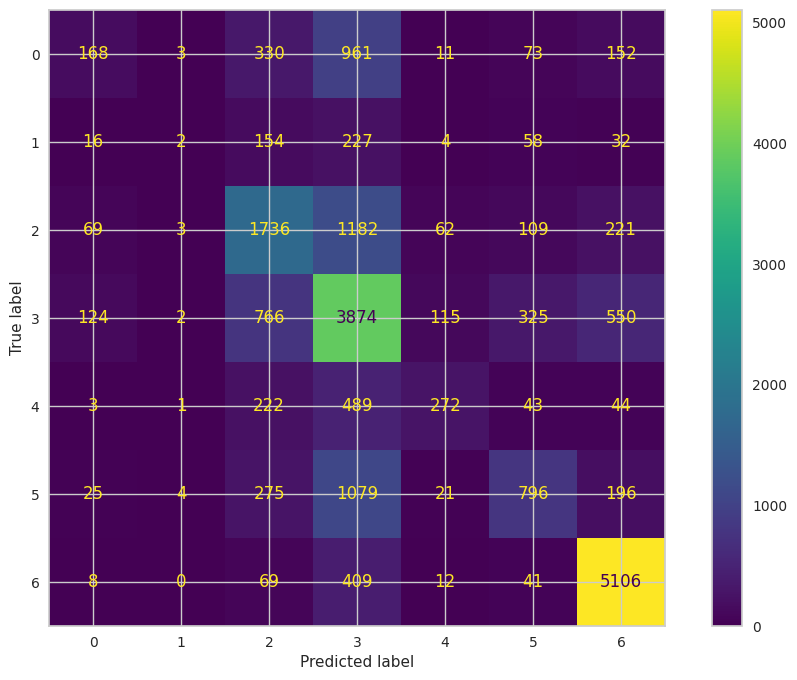

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = forest.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=forest.classes_)
cmp.plot(ax=ax)

plt.show();

In [114]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.54      0.59      5721
           1       0.76      0.86      0.81      5756
           2       0.58      0.48      0.52      5755
           3       0.45      0.50      0.47      5755
           4       0.76      0.85      0.80      5755
           5       0.65      0.52      0.58      5756
           6       0.76      0.90      0.82      5756

    accuracy                           0.66     40254
   macro avg       0.66      0.66      0.66     40254
weighted avg       0.66      0.66      0.66     40254



In [108]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.51      0.05      0.09      1698
           1       0.00      0.00      0.00       493
           2       0.51      0.50      0.51      3382
           3       0.46      0.71      0.56      5756
           4       0.53      0.30      0.38      1074
           5       0.57      0.23      0.33      2396
           6       0.80      0.91      0.85      5645

    accuracy                           0.58     20444
   macro avg       0.48      0.39      0.39     20444
weighted avg       0.57      0.58      0.54     20444



In [102]:
## Tuning Model
for i in range(3):
    tree = forest.estimators_[i]
    dot_data = export_graphviz(
        tree,
        feature_names=feat_df.iloc[:, :-1].columns,
        filled=True,
        max_depth=2,
        impurity=False,
        proportion=True,
    )
    graph = graphviz.Source(dot_data)
    display(graph)

ValueError: Length of feature_names, 94 does not match number of features, 93

In [103]:
param_dist = {"n_estimators": randint(50, 500), "max_depth": randint(1, 20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5b80981370>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5b808c9e50>})

In [105]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 440}


In [ ]:
feat_labels = feat_df.iloc[:, :-1].columns
feat_labels

In [ ]:
importances = forest.feature_importances_

In [ ]:
importances

In [ ]:
# for f in range(X_train.shape[1]):
#     print("%2d) %-*s %f" % (f + 1, 30,
#     feat_labels[indices[f]],
#     importances[indices[f]]))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

In [ ]:
for f in range(X_train.shape[1]):
    print(
        "%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]])
    )

In [ ]:
## 0 - Student
## 1- Data Scientist
## 2- Data Analyst
## 3- SE
## 4- Professor
## 5- MLOPS
##6- DE
## drop the rows which has not employed.

In [ ]:
### Feature selection

In [ ]:
feat_df.corr()